In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import seaborn as sns; sns.set_style();
import pytorch_lightning as pl
from model.model_rnn import ModelRNN
from PIL import Image
import pandas as pd

In [2]:
device = 'cpu'
model = ModelRNN.load_from_checkpoint('/home/python/Documents/Thesis/exp_weights/rnn_exp/rnn_256hidden_512attn/lightning_logs/version_1/checkpoints/epoch=37.ckpt', map_location=device)
model.eval();

In [3]:
image_transform = model.transform.test

In [4]:
path = 'data/VNOnDB/word/train_word/20140603_0003_BCCTC_tg_0_0_3.png'
csv = 'data/VNOnDB/word/train_word_new.csv'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


128 49


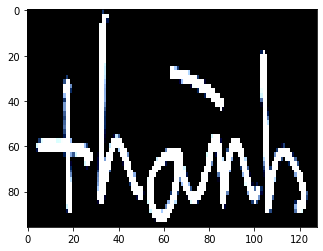

In [5]:
image = Image.open(path).convert('L')
width, height = image.size
print(width, height)
image = image_transform(image)
plt.imshow(image.permute(1,2,0))

In [6]:
df = pd.read_csv(csv, sep='\t', keep_default_na=False)
gt = df.loc[df['id']==path.split('/')[-1], 'label'].values[0]
print(f"Ground truth: {gt}")

Ground truth: thành


In [7]:
with torch.no_grad():
    outputs, lengths, enc_dec_weights = model.decode(image.unsqueeze(0), 15, 1, output_weights=True)
    for (output, length) in zip(outputs.cpu().tolist(), lengths.cpu().tolist()):
        output = list(map(model.vocab.int2char, output[:length]))
        output = model.vocab.process_label_invert(output)
        output = ' '.join(output)
        print(output)

t h à n h <end>


torch.Size([1, 1, 6, 192])


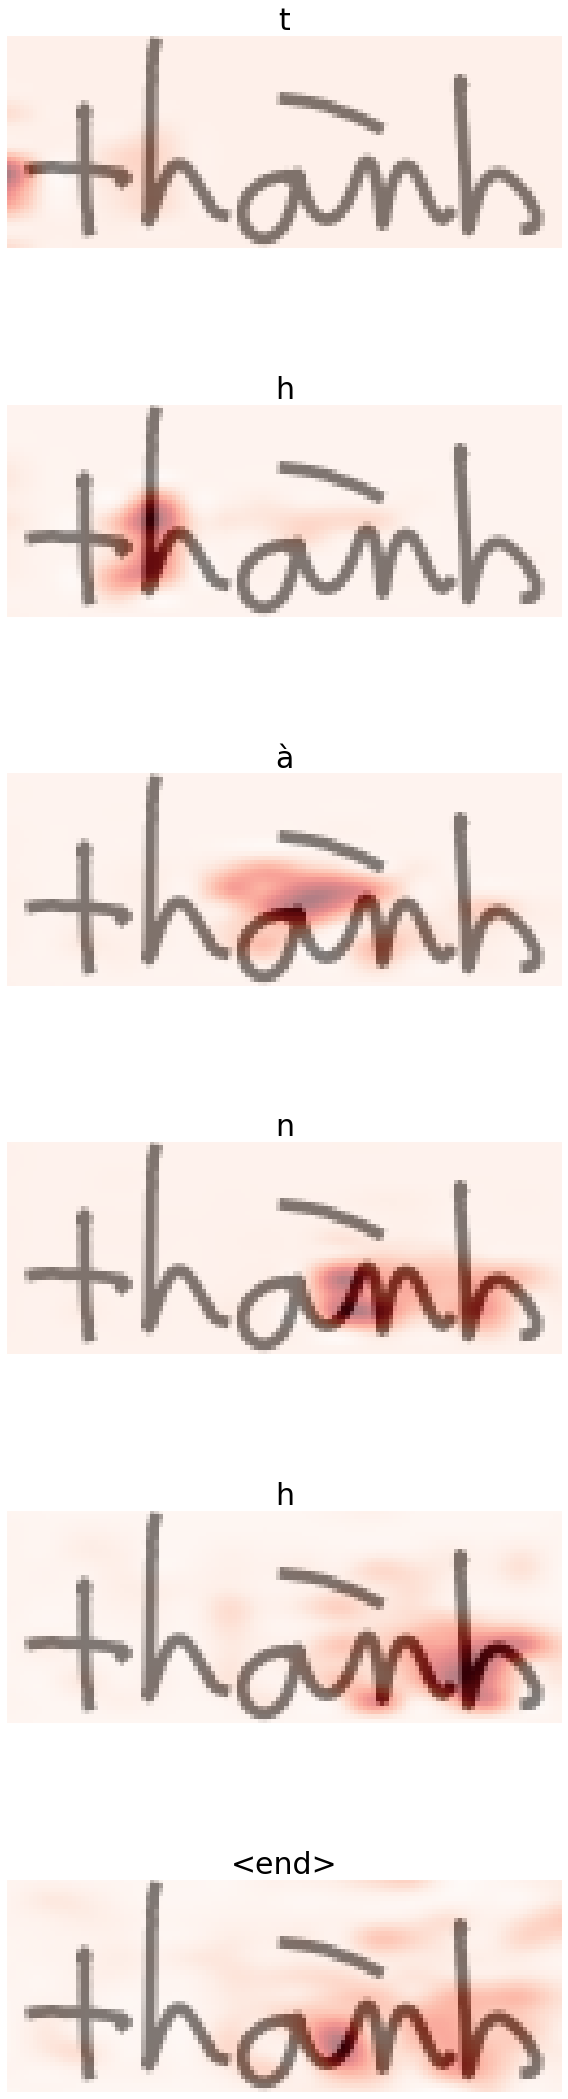

In [9]:
def visualize_enc_dec_weights(weights, layer_idx=-1):
    print(weights.shape) # [L,B,T,S]
    L, B, T, S = weights.shape
    alpha = 0.7
    fig, axes = plt.subplots(T, B, figsize=(8, 30), sharex=True, sharey=True, squeeze=False)

    weights = weights[layer_idx] # [B, T, S]

    for i, sample in enumerate(weights):
        # sample: [T, S]
        output = list(map(model.vocab.int2char, outputs[i]))
        output = model.vocab.process_label_invert(output)
        for j, weight in enumerate(sample):
            # weight: [S] -> [H, W]
            weight = weight.reshape(16, 12)
            weight = weight.transpose(-2, -1)
            weight = F.interpolate(weight.unsqueeze(0).unsqueeze(0), (height, width), mode='bicubic', align_corners=True) # 1,H,W
            weight = weight.squeeze(0).squeeze(0) # H,W
    
            image = Image.open(path).convert('L').resize((width, height))

            axes[j, i].set_title(output[j], fontdict={'fontsize': 30, 'fontweight': 'medium'})
            axes[j, i].axis('off')
            axes[j, i].imshow(weight, cmap='Reds', alpha=1)
            axes[j, i].imshow(image, cmap='gray', alpha=0.5)
            extent = axes[j, i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            fig.savefig(f'misc/rnn_attn-enc-dec_{gt}_{j}.png', bbox_inches=extent.expanded(1, 1.1))
            
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0.25)
    plt.show()
visualize_enc_dec_weights(enc_dec_weights[:, [0]]) # visualize first sample only

torch.Size([1, 1, 6, 192])


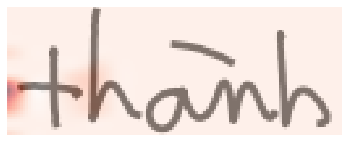

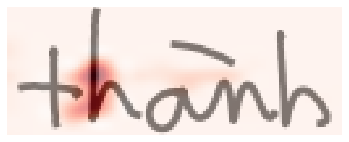

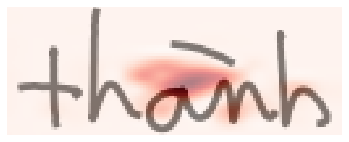

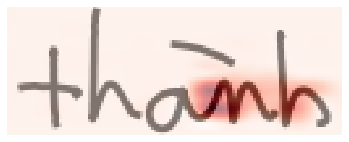

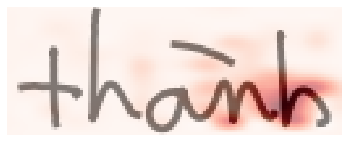

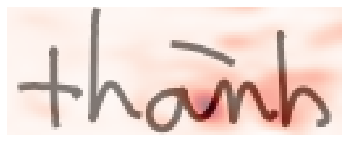

In [10]:
def visualize_enc_dec_weights_1(weights, layer_idx=-1):
    print(weights.shape) # [L,B,T,S]
    L, B, T, S = weights.shape
    alpha = 0.7

    weights = weights[layer_idx] # [B, T, S]

    for i, sample in enumerate(weights):
        # sample: [T, S]
        output = list(map(model.vocab.int2char, outputs[i]))
        output = model.vocab.process_label_invert(output)
        for j, weight in enumerate(sample):
            # weight: [S] -> [H, W]
            weight = weight.reshape(16, 12)
            weight = weight.transpose(-2, -1)
            weight = F.interpolate(weight.unsqueeze(0).unsqueeze(0), (height, width), mode='bicubic', align_corners=True) # 1,H,W
            weight = weight.squeeze(0).squeeze(0) # H,W
    
            image = Image.open(path).convert('L').resize((width, height))

            plt.axis('off')
            fig = plt.imshow(weight, cmap='Reds', alpha=1)
            fig = plt.imshow(image, cmap='gray', alpha=0.5)
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)
            plt.savefig(f'misc/rnn_attn-enc-dec_{gt}_{j}_1.png', bbox_inches='tight', pad_inches = 0)
            plt.show()
            
visualize_enc_dec_weights_1(enc_dec_weights[:, [0]]) # visualize first sample only